# Plant Classification Using Transfer Learning - VGG16

Having previously used MobilenetV2 in a previous notebook, in this notebook I use vgg16 for Transfer Learning.<br>
The dataset can be accessed from Kaggle [here](https://www.kaggle.com/datasets/csafrit2/plant-leaves-for-image-classification)

### 0.Load Libraries

In [ ]:
import os
import tensorflow as tf
import glob as glob
import matplotlib.pyplot as plt
import random
import numpy as np
from dataclasses import dataclass  
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers

plt.rcParams['figure.figsize'] = (12, 9)
block_plot = False

# Fix seeds for reproducibility.
SEED_VALUE = 42
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE) 

os.environ["TF_DETERMINISTIC_OPS"] = "1"

# For GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["CUDNN_DETERMINISTIC"] = "1"

### 1.Import Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip the data file and save in 
!unzip drive/My\ Drive/Colab\ Notebooks/Datasets/PlantClassification_dataset/PlantClassification_dataset.zip > /dev/null

In [ ]:
# Navigate to directory for extraction
#%cd /content/drive/MyDrive/Colab Notebooks/Datasets/PlantClassification_dataset/

# Extract and save data
#!unzip PlantClassification_dataset.zip

#### Set Config Parameters:

In [ ]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES:  int = 22   
    IMG_HEIGHT:   int = 224
    IMG_WIDTH:    int = 224
    CHANNELS: int = 3
    BATCH_SIZE:   int = 32
    DATA_ROOT_TRAIN:    str = '/content/Plants_2/train'
    DATA_ROOT_VALID: str = '/content/Plants_2/valid'

@dataclass(frozen=True)
class TrainingConfig:
    EPOCHS:         int   = 45
    LEARNING_RATE:  float = 0.0002
    BATCH_SIZE: int = 32
    CHECKPOINT_DIR: str   = '/content/Plants_2/Checkpoint'


### 2.VGG16 - Load and Config:

In [ ]:
tf.keras.applications.vgg16.VGG16(include_top=True, 
                                  weights='imagenet', 
                                  input_tensor=None,
                                  input_shape=None, 
                                  pooling=None, 
                                  classes=1000,
                                  classifier_activation='softmax',
                                 )

553467096/553467096 [==============================] - 2s 0us/step


In [ ]:
input_shape = (DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, DatasetConfig.CHANNELS)

print('Loading model with ImageNet weights...')
vgg16_conv_base = tf.keras.applications.vgg16.VGG16(input_shape=input_shape,
                                                    include_top=False, # We will supply our own top.
                                                    weights='imagenet',
                                                   )
# Set the `trainable` attribute of the convolutional base to `False` so that the weights are not changed.
vgg16_conv_base.trainable = False
print('All weights trainable, fine tuning...')

Loading model with ImageNet weights...
58889256/58889256 [==============================] - 0s 0us/step
All weights trainable, fine tuning...


In [ ]:
print(vgg16_conv_base.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### Add Classification Layer

In [ ]:
inputs = tf.keras.Input(shape=input_shape)
    
x = tf.keras.applications.vgg16.preprocess_input(inputs)
    
x = vgg16_conv_base(x)

x = layers.Flatten()(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.25)(x)
    
# The final `Dense` layer with the number of classes.
outputs = layers.Dense(DatasetConfig.NUM_CLASSES, activation='softmax')(x)
    
# The final model.
vgg16_model = keras.Model(inputs, outputs)

print(vgg16_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                             

##3.Prepare and Display Data

In [ ]:
# Access datasets and convert to the appropriate image size
train_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_TRAIN,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             seed=SEED_VALUE,
                                             label_mode='categorical',
                                             image_size=(DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT),
                                             )

valid_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_VALID,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             seed=SEED_VALUE,
                                             label_mode='categorical',
                                             image_size=(DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT),
                                             )

Found 4274 files belonging to 22 classes.
Found 110 files belonging to 22 classes.


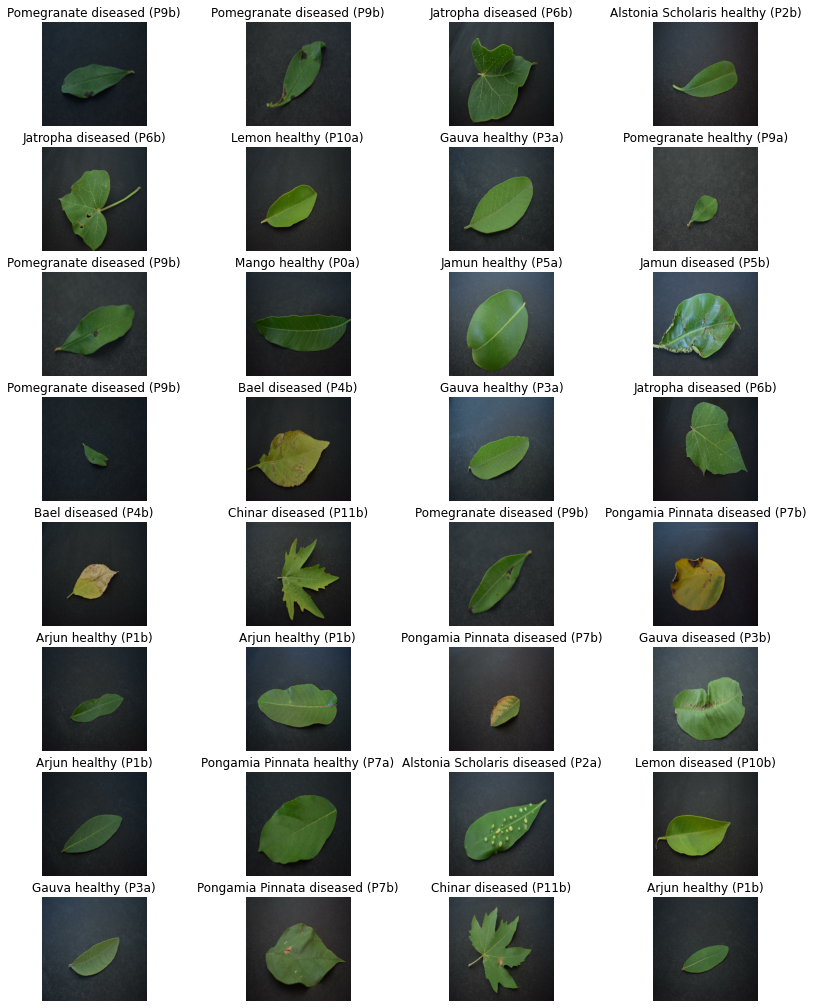

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(14, 18))

# Assumes dataset batch_size is at least 32.
num_rows = 8
num_cols = 4

# Here we use the take() method to retrieve just the first batch of data from the training portion of the dataset.
for image_batch, labels_batch in train_dataset.take(1): 
    
    # For the batch of images and the associated (one-hot encoded) labels, 
    # plot each of the images in the batch and the associated ground truth labels.
    for idx in range(num_rows*num_cols):
        ax = plt.subplot(num_rows, num_cols, idx + 1)
        plt.imshow(image_batch[idx].numpy().astype("uint8"))
        truth_idx = np.nonzero(labels_batch[idx].numpy())
        plt.title(class_names[truth_idx[0][0]])
        plt.axis("off")

In [ ]:
# View all classes
class_names

['Alstonia Scholaris diseased (P2a)',
 'Alstonia Scholaris healthy (P2b)',
 'Arjun diseased (P1a)',
 'Arjun healthy (P1b)',
 'Bael diseased (P4b)',
 'Basil healthy (P8)',
 'Chinar diseased (P11b)',
 'Chinar healthy (P11a)',
 'Gauva diseased (P3b)',
 'Gauva healthy (P3a)',
 'Jamun diseased (P5b)',
 'Jamun healthy (P5a)',
 'Jatropha diseased (P6b)',
 'Jatropha healthy (P6a)',
 'Lemon diseased (P10b)',
 'Lemon healthy (P10a)',
 'Mango diseased (P0b)',
 'Mango healthy (P0a)',
 'Pomegranate diseased (P9b)',
 'Pomegranate healthy (P9a)',
 'Pongamia Pinnata diseased (P7b)',
 'Pongamia Pinnata healthy (P7a)']

##4.Prepare and Evaluate Base Model

In [ ]:
vgg16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=TrainingConfig.LEARNING_RATE),
                    loss=tf.keras.losses.CategoricalCrossentropy(),
                    metrics=['accuracy'],
                   )  

The best model is saved in Plant2 directory. It can be loaded and used at a later time.

In [ ]:
# Save best model based on highest validation_accuracy.
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=TrainingConfig.CHECKPOINT_DIR,
                                                               save_weights_only=False,
                                                               monitor='val_accuracy',
                                                               mode='max',
                                                               save_best_only=True,
                                                              )

In [ ]:
# Accuracy before transfer learning:
print(f"Model evaluation accuracy: {vgg16_model.evaluate(valid_dataset)[1]*100.:.3f}")

4/4 [==============================] - 10s 123ms/step - loss: 9.9662 - accuracy: 0.0636
Model evaluation accuracy: 6.364


##5.Train and Evaluate Model

### Data Augmentation

In [ ]:
data_augmentation = keras.Sequential(
  [
    keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                         input_shape=(DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT,3)),
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.experimental.preprocessing.RandomZoom(0.1),
    keras.layers.experimental.preprocessing.RandomContrast(factor=(0.9, 1.0))
  ]
)

In [ ]:
aug_ds = train_dataset.map(
  lambda x, y: (data_augmentation(x, training=True), y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
#from keras.api._v2.keras.callbacks import EarlyStopping
# Train the Model.
training_results = vgg16_model.fit(aug_ds,
                                   validation_data=valid_dataset,
                                   epochs=TrainingConfig.EPOCHS,
                                   workers=4,
                                   use_multiprocessing=True, 
                                   callbacks=model_checkpoint_callback,                                  
                                  )

Epoch 1/45
134/134 [==============================] - ETA: 0s - loss: 2.5526 - accuracy: 0.4429

134/134 [==============================] - 334s 2s/step - loss: 2.5526 - accuracy: 0.4429 - val_loss: 1.1240 - val_accuracy: 0.6364
Epoch 2/45
134/134 [==============================] - ETA: 0s - loss: 1.1323 - accuracy: 0.6792

134/134 [==============================] - 330s 2s/step - loss: 1.1323 - accuracy: 0.6792 - val_loss: 0.8673 - val_accuracy: 0.7455
Epoch 3/45
134/134 [==============================] - 328s 2s/step - loss: 0.8018 - accuracy: 0.7658 - val_loss: 0.7265 - val_accuracy: 0.7364
Epoch 4/45
134/134 [==============================] - ETA: 0s - loss: 0.6611 - accuracy: 0.8035

134/134 [==============================] - 331s 2s/step - loss: 0.6611 - accuracy: 0.8035 - val_loss: 0.8827 - val_accuracy: 0.7636
Epoch 5/45
134/134 [==============================] - ETA: 0s - loss: 0.5604 - accuracy: 0.8320

134/134 [==============================] - 331s 2s/step - loss: 0.5604 - accuracy: 0.8320 - val_loss: 0.8424 - val_accuracy: 0.7909
Epoch 6/45
134/134 [==============================] - 328s 2s/step - loss: 0.4664 - accuracy: 0.8573 - val_loss: 0.8387 - val_accuracy: 0.7909
Epoch 7/45
134/134 [==============================] - 327s 2s/step - loss: 0.4276 - accuracy: 0.8694 - val_loss: 0.8620 - val_accuracy: 0.7636
Epoch 8/45
134/134 [==============================] - ETA: 0s - loss: 0.4172 - accuracy: 0.8779

134/134 [==============================] - 331s 2s/step - loss: 0.4172 - accuracy: 0.8779 - val_loss: 0.7459 - val_accuracy: 0.8364
Epoch 9/45
134/134 [==============================] - ETA: 0s - loss: 0.3558 - accuracy: 0.8889

134/134 [==============================] - 331s 2s/step - loss: 0.3558 - accuracy: 0.8889 - val_loss: 0.9093 - val_accuracy: 0.8455
Epoch 10/45
134/134 [==============================] - 328s 2s/step - loss: 0.3197 - accuracy: 0.9052 - val_loss: 0.7925 - val_accuracy: 0.8091
Epoch 11/45
134/134 [==============================] - 327s 2s/step - loss: 0.2957 - accuracy: 0.9036 - val_loss: 0.9986 - val_accuracy: 0.7818
Epoch 12/45
134/134 [==============================] - 328s 2s/step - loss: 0.3300 - accuracy: 0.9045 - val_loss: 1.0736 - val_accuracy: 0.8091
Epoch 13/45
134/134 [==============================] - 327s 2s/step - loss: 0.2545 - accuracy: 0.9235 - val_loss: 1.3186 - val_accuracy: 0.7909
Epoch 14/45
134/134 [==============================] - 327s 2s/step - loss: 0.2557 - accuracy: 0.9235 - val_loss: 0.9391 - val_accuracy: 0.8091
Epoch 15/45
134/134 [==============================] - 327s 2s/step - loss: 0.2631 - accuracy: 0.9204 - val_loss: 1.1751 - val_accuracy: 0.8000
Epoc

134/134 [==============================] - 331s 2s/step - loss: 0.1266 - accuracy: 0.9616 - val_loss: 1.1532 - val_accuracy: 0.8545
Epoch 44/45
134/134 [==============================] - 328s 2s/step - loss: 0.1356 - accuracy: 0.9598 - val_loss: 1.1931 - val_accuracy: 0.8182
Epoch 45/45
134/134 [==============================] - 328s 2s/step - loss: 0.1318 - accuracy: 0.9633 - val_loss: 1.9173 - val_accuracy: 0.7545


In [ ]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)

def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):
    
    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]
        
    for idx, metric in enumerate(metrics):    
        ax.plot(metric, color=color[idx])
    
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, TrainingConfig.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(2))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)   
    plt.show(block=block_plot)
    plt.close()

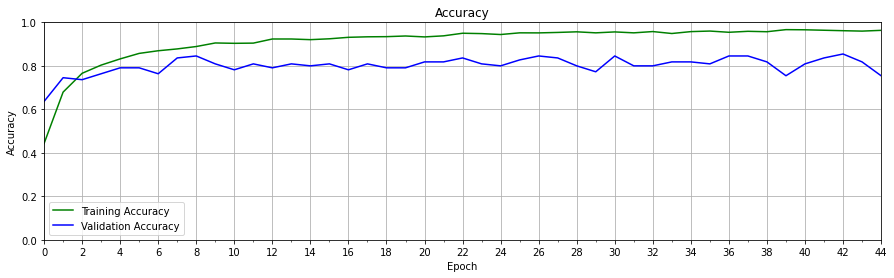

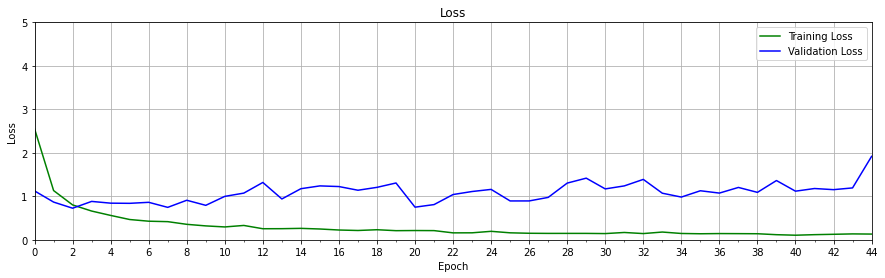

In [ ]:
# Retrieve training results.
train_loss = training_results.history["loss"]
train_acc  = training_results.history["accuracy"]
valid_loss = training_results.history["val_loss"]
valid_acc  = training_results.history["val_accuracy"]
    
plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            ylim = [0.0, 5.0],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

In [ ]:
# Load saved model.
# Final evaluation accuracy on the validation set.
model = tf.keras.models.load_model(TrainingConfig.CHECKPOINT_DIR)
print(f"Model evaluation accuracy: {model.evaluate(valid_dataset)[1]*100.:.3f}")

4/4 [==============================] - 1s 20ms/step - loss: 1.1532 - accuracy: 0.8545
Model evaluation accuracy: 85.455


In [ ]:
def display_wrong_predictions(dataset, checkpoint_dir=None, checkpoint_version=0):
    
    if not checkpoint_dir:
        checkpoint_dir = os.path.join(os.getcwd(), TrainingConfig.checkpoint_dir, f"version_{checkpoint_version}")
        
    # Load saved model.
    model = tf.keras.models.load_model(checkpoint_dir)
    
    plt.figure(figsize=(15, 20))
    num_rows = 5
    num_cols = 3
    class_names = dataset.class_names
    jdx = 0
    
    # Evaluate all the batches.
    for image_batch, labels_batch in dataset:
        
        # Predictions for the current batch.
        predictions = model.predict(image_batch)
        
        # Loop over all the images in the current batch.
        for idx in range(len(labels_batch)):
            
            pred_idx = tf.argmax(predictions[idx]).numpy()
            truth_idx = np.nonzero(labels_batch[idx].numpy())
            
            # Plot the images with incorrect predictions
            if pred_idx != truth_idx:
                
                jdx += 1
                
                if jdx > num_rows*num_cols:
                    # Break from the loops if the maximum number of images have been plotted
                    break
                
                ax = plt.subplot(num_rows, num_cols, jdx)
                title = str(class_names[truth_idx[0][0]]) + " : " + str(class_names[pred_idx])
                title_obj = plt.title(title)
                plt.setp(title_obj, color='r')
                plt.axis("off")
                plt.imshow(image_batch[idx].numpy().astype("uint8"))
    return 

1/1 [==============================] - 0s 183ms/step


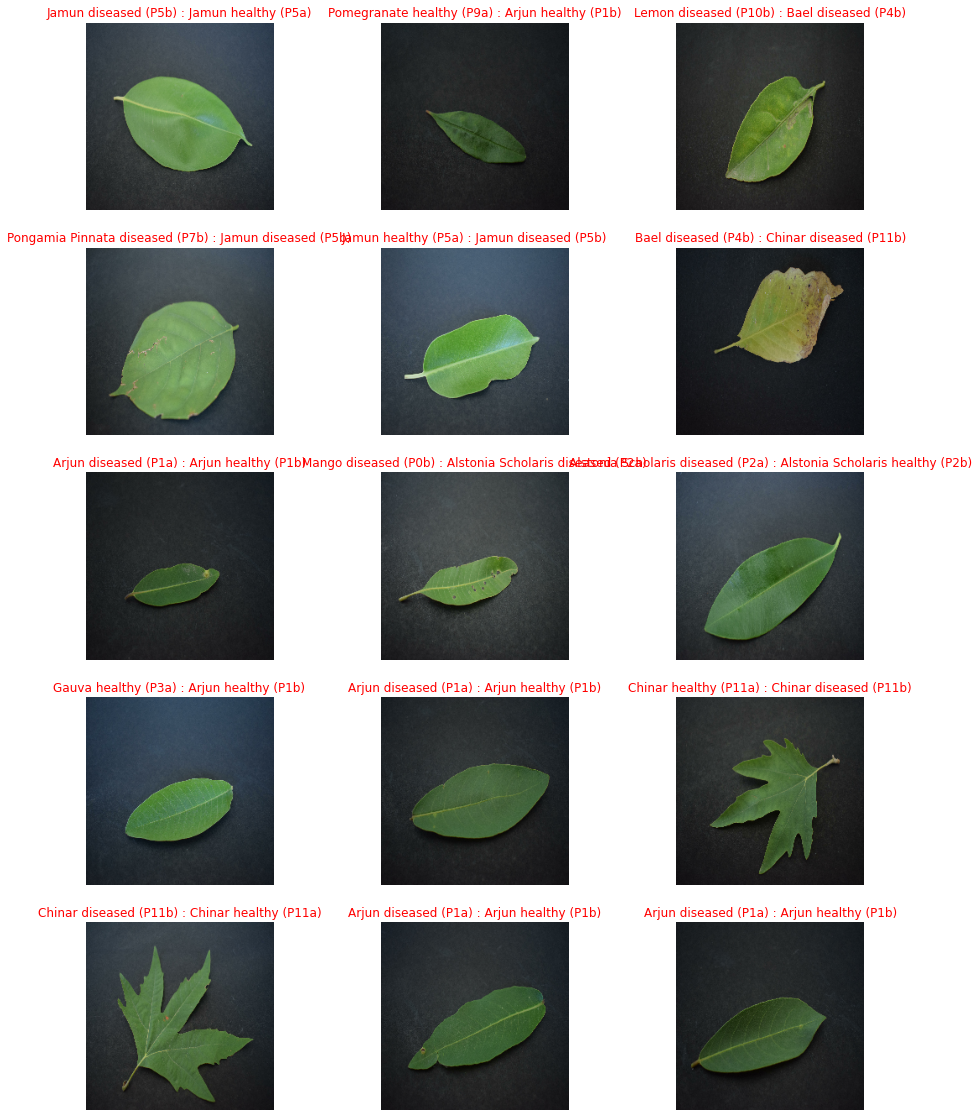

In [ ]:
display_wrong_predictions(valid_dataset, TrainingConfig.CHECKPOINT_DIR)

Save transfer model in Google Drive.

In [ ]:
#model.save('/content/drive/MyDrive/Colab Notebooks/Datasets/PlantClassification_dataset/Models/plantclass_aug_transfermodel')

### Test Model on "Blind" data

In [ ]:
# load trained model

model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Datasets/PlantClassification_dataset/Models/plantclass_aug_transfermodel')


In [ ]:
# Config test_data
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES:  int = 22   
    IMG_HEIGHT:   int = 224
    IMG_WIDTH:    int = 224
    CHANNELS: int = 3
    BATCH_SIZE:   int = 32
    DATA_ROOT_TEST:    str = '/content/Plants_2/test'



@dataclass(frozen=True)
class TrainingConfig:
    EPOCHS:         int   = 21
    LEARNING_RATE:  float = 0.001
    BATCH_SIZE: int = 32
    #CHECKPOINT_DIR: str   = '/content/drive/MyDrive/Colab Notebooks/Datasets/Plants_2'
    
test_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_TEST,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             seed=SEED_VALUE,
                                             label_mode='categorical',
                                             image_size=(DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT),
                                             )



Found 110 files belonging to 22 classes.


In [ ]:
print(f"Model evaluation accuracy: {model.evaluate(test_dataset)[1]*100.:.3f}")

4/4 [==============================] - 2s 21ms/step - loss: 0.8475 - accuracy: 0.8909
Model evaluation accuracy: 89.091


In [ ]:
def evaluate_model(dataset, model):
    
    num_matches = 0
    plt.figure(figsize=(18, 20))
    num_rows = 10
    num_cols = 3
    class_names = dataset.class_names
    
    # Retrieve a single batch.
    for data_batch, labels_batch in dataset.take(1):
        
        predictions = model.predict(data_batch)
        
        for idx in range(num_rows*num_cols):
            ax = plt.subplot(num_rows, num_cols, idx + 1)
            plt.axis("off")
            plt.imshow(data_batch[idx].numpy().astype("uint8"))
            plt.savefig('/content/drive/MyDrive/Colab Notebooks/Datasets/PlantClassification_dataset/Saved_Pred_Images/test_data_aug_transfermodel.png')

            pred_idx = tf.argmax(predictions[idx]).numpy()
            truth_idx = np.nonzero(labels_batch[idx].numpy())
            
            title = str(class_names[truth_idx[0][0]]) + " : " + str(class_names[pred_idx])
            title_obj = plt.title(title, fontdict={'fontsize':11})
            
            # plot images with correct predictions
            if pred_idx == truth_idx:
                num_matches += 1
                plt.setp(title_obj, color='g')
            else:
                plt.setp(title_obj, color='r')
                
            acc = num_matches/(idx+1)
        print("Prediction accuracy: ", int(100*acc)/100)
    
    return

1/1 [==============================] - 0s 53ms/step
Prediction accuracy:  0.9


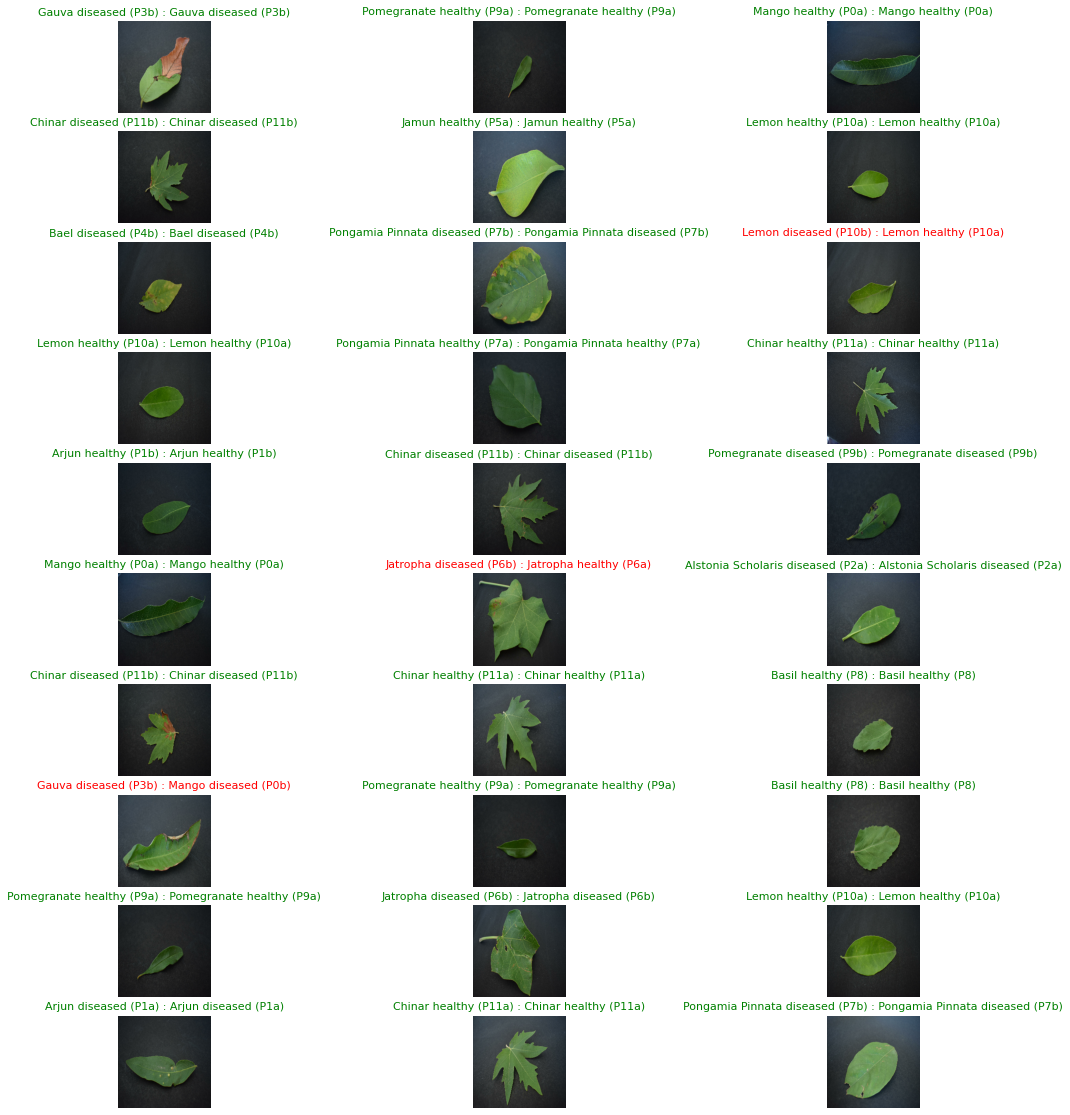

In [ ]:
evaluate_model(test_dataset, model)